## 3. 버트를 활용한 한국어 자연어 추론 모델
지금까지는 버트를 활용해 감정 분류에 대한 미세 조정을 진행

이번에는 2개의 문장을 입력으로 하는 자연어 추론 문제  
KorNLI 데이터를 활용해 전처리 수행 및 모델 구성 


### 1) KorNLI 데이터 분석   
카카오 브레인에서 공개한 새로운 한국어 벤치마크 셋인 KorNLI 데이터 분석 

- KorNLI 깃허브 저장소 : https://github.com/kakaobrain/KorNLUDatasets

이제 데이터를 살펴보자

In [2]:
import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [11]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# KorNLI Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [12]:
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')

multinli_data = pd.read_csv(TRAIN_XNLI_DF, sep='\t', error_bad_lines=False) # error_bad_lines=False를 통해 에러가 나는 구간 무시 
multinli_data.head(10)

b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
5,내 워커가 고장나서 지금 화가 났어. 스테레오를 정말 크게 틀어야 해.,나는 내 워크맨이 고장나서 화가 나서 이제 스테레오를 정말 크게 틀어야 한다.,entailment
6,그러나 apse 위에서 살아남은 기독교 모자이크 몇 개는 아기 예수와 함께 성모인데...,기독교 모자이크의 대부분은 이슬람교도들에 의해 파괴되었다.,neutral
7,(슬레이트에 대한 읽기는 잭슨의 연구 결과를 받아들인다.),슬레이트는 잭슨의 발견에 대해 의견을 가지고 있었다.,entailment
8,게이들과 레즈비언들.,이성애자.,contradiction
9,Rue des Francs-Bourgeois의 끝에는 많은 사람들이 돌과 붉은 벽돌...,Place des Vosges는 전적으로 회색 대리석으로 만들어졌다.,contradiction


- sentence1과 sentence2는 각각 첫 번째 문장과 두 번째 문장을 의미  
- gold_label은 해당 문장의 정답을 의미
- 정답은 수반(entailment), 모순(contradiction), 중립(neutral)의 세 가지 값

In [13]:
print('전체 multinli_data 개수 : {}'.format(len(multinli_data)))

전체 multinli_data 개수 : 385494


In [14]:
TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')

snli_data = pd.read_csv(TRAIN_SNLI_DF, sep='\t', error_bad_lines = False)
snli_data.head(10)

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
5,카메라에 웃고 손을 흔드는 아이들,아이들이 얼굴을 찌푸리고 있다,contradiction
6,한 소년이 빨간 다리 한가운데 스케이트보드에 뛰어오르고 있다.,소년은 인도를 따라 스케이트를 탄다.,contradiction
7,한 소년이 빨간 다리 한가운데 스케이트보드에 뛰어오르고 있다.,그 소년은 스케이트보드를 타는 묘기를 부린다.,entailment
8,한 소년이 빨간 다리 한가운데 스케이트보드에 뛰어오르고 있다.,소년이 안전 장비를 착용하고 있다.,neutral
9,나이 든 남자가 커피숍의 작은 테이블에 오렌지 주스를 들고 앉아 있고 밝은 색 셔츠...,나이 든 남자가 딸이 퇴근하기를 기다리면서 주스를 마신다.,neutral


In [15]:
print('전체 snli 개수 : {}'.format(len(snli_data)))

전체 snli 개수 : 550152


이제 두 파일의 데이터를 하나로 합쳐보자 

In [16]:
train_data = pd.concat([multinli_data, snli_data], axis = 0)
train_data.head(10)

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
5,내 워커가 고장나서 지금 화가 났어. 스테레오를 정말 크게 틀어야 해.,나는 내 워크맨이 고장나서 화가 나서 이제 스테레오를 정말 크게 틀어야 한다.,entailment
6,그러나 apse 위에서 살아남은 기독교 모자이크 몇 개는 아기 예수와 함께 성모인데...,기독교 모자이크의 대부분은 이슬람교도들에 의해 파괴되었다.,neutral
7,(슬레이트에 대한 읽기는 잭슨의 연구 결과를 받아들인다.),슬레이트는 잭슨의 발견에 대해 의견을 가지고 있었다.,entailment
8,게이들과 레즈비언들.,이성애자.,contradiction
9,Rue des Francs-Bourgeois의 끝에는 많은 사람들이 돌과 붉은 벽돌...,Place des Vosges는 전적으로 회색 대리석으로 만들어졌다.,contradiction


In [17]:
print('전체 train_data 개수 : {}'.format(len(train_data)))

전체 train_data 개수 : 935646


In [18]:
# 문장 분석 → 문장 1, 문장 2를 합친다. 
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
train_set.head()

0           개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.
1    시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...
2                    우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.
3                         어떻게 아세요? 이 모든 것이 다시 그들의 정보다.
4    그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...
dtype: object

문장의 음절 단위, 띄어쓰기 단위, 버트 토크나이저 단위로 데이터를 분석하기 위해 두 개로 나눠져 있는 각 문장을 하나로 합친다.  

합친 문장의 데이터 개수를 출력 

In [19]:
print('전체 데이터의 개수 : {}'.format(len(train_set)))

전체 데이터의 개수 : 1871292


중복된 문장이 있는지 확인 

In [20]:
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

유일한 총 문장 수 : 1105355
반복해서 나타나는 문장의 수: 308368


맷플롯립을 통해 시각화  
x = 중복 문장의 개수   
y = 중복 횟수가 동일한 문장의 개수

Text(0, 0.5, 'Number of sentence')

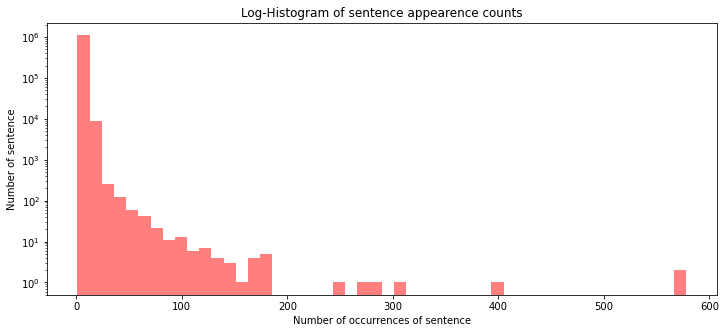

In [21]:
# 그래프에 대한 이미지 크기 선언 
# figsize : (가로, 세로)형태의 튜플로 입력 
plt.figure(figsize=(12, 5))
# 히스토그램 선언 
# bins : 히스토그램 값들에 대한 버킷 범위 
# range : x축 값의 범위 
# alpha : 그래프 색상 투명도 
# color : 그래프 색상 
# label : 그래프에 대한 라벨 
plt.hist(train_set.value_counts(), bins =50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목 
plt.title('Log-Histogram of sentence appearence counts')
# 그래프 x축 라벨 
plt.xlabel('Number of occurrences of sentence')
# 그래프 y축 라벨 
plt.ylabel('Number of sentence')

- 중복 횟수가 1인 질문들이 가장 많음 
- 이상치 값이 다수 존재   

중복 분포를 통계치로 수치화 

In [23]:
print('중복 최대 개수 : {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수 : {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수 : {}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차 : {}'.format(np.std(train_set.value_counts())))
print('중복 중간 길이 : {}'.format(np.median(train_set.value_counts())))

print('제1사분위 중복 : {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제3사분위 중복 : {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수 : 578
중복 최소 개수 : 1
중복 평균 개수 : 1.6929330396117084
중복 표준편차 : 2.2311895824512398
중복 중간 길이 : 1.0
제1사분위 중복 : 1.0
제3사분위 중복 : 3.0


중복 평균이 1.69라는 것은 최소 1개 이상 중복돼 있음을 의미  

박스 플롯으로 중복 횟수를 시각화

{'whiskers': [<matplotlib.lines.Line2D at 0x25c0125dc10>,
 'caps': [<matplotlib.lines.Line2D at 0x25c0127c310>,
 'boxes': [<matplotlib.lines.Line2D at 0x25c0125d8b0>],
 'medians': [<matplotlib.lines.Line2D at 0x25c0127c9d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25c0129b070>],
 'means': [<matplotlib.lines.Line2D at 0x25c0127ccd0>]}

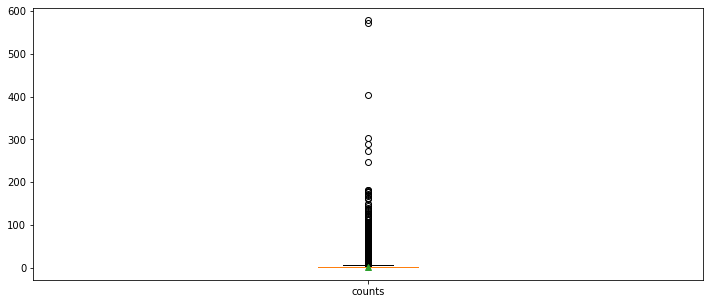

In [24]:
plt.figure(figsize=(12, 5))
# 박스 플롯 생성 
# 첫 번째 파라미터 : 여러 분포에 대한 데이터 리스트를 입력 
# labels : 입력한 데이터에 대한 라벨 
# showmeans : 평균값을 마크함 

plt.boxplot([train_set.value_counts()],
           labels=['counts'],
           showmeans=True)

In [25]:
# 버트 토크나이저로 토크나이징한 결과 
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [26]:
# 버트 토크나이저 호출 
train_bert_token_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Probability')

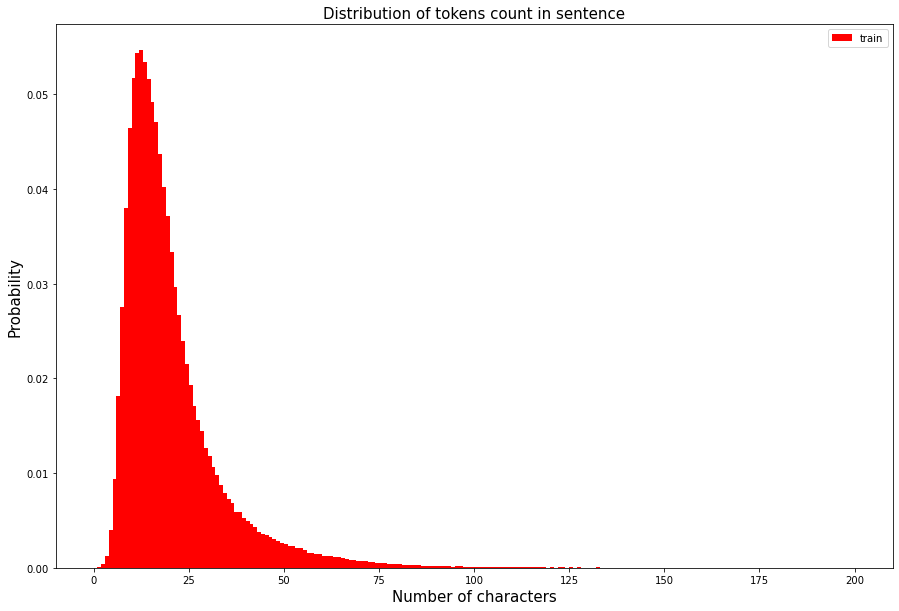

In [30]:
# 각 문장을 버트 토크나이저를 통해 하위 토큰으로 분류한 개수 값을 train_bert_token_counts에 넣고 해당 값을 분석 
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_counts, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Distribution of tokens count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

데이터에 들어있는 문장의 길이 분포는 3~125까지이며 그 이후에는 빈도수가 거의 없다.   

이제 길이값을 사용해 통계값을 확인 

In [36]:
print('문장 tokens 개수 최댓값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균값 : {}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차 : {}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간값 : {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제1사분위 : {}'.format(np.percentile(train_bert_token_counts,25)))

print('문장 tokens 개수 제3사분위 : {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99퍼센트 : {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최댓값: 9006
문장 tokens 개수 평균값 : 20.24058030494439
문장 tokens 개수 표준편차 : 26.76967148880729
문장 tokens 개수 중간값 : 16.0
문장 tokens 개수 제1사분위 : 11.0
문장 tokens 개수 제3사분위 : 24.0
문장 tokens 개수 99퍼센트 : 72.0


- 통계값을 보아 평균적으로 길이가 26 정도라는 것을 확인  
- 중간값은 16 정도   

박스 플롯 확인 

{'whiskers': [<matplotlib.lines.Line2D at 0x25c01463b20>,
 'caps': [<matplotlib.lines.Line2D at 0x25c0146a220>,
 'boxes': [<matplotlib.lines.Line2D at 0x25c014637c0>],
 'medians': [<matplotlib.lines.Line2D at 0x25c0146a8e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25c0146af40>],
 'means': [<matplotlib.lines.Line2D at 0x25c0146abe0>]}

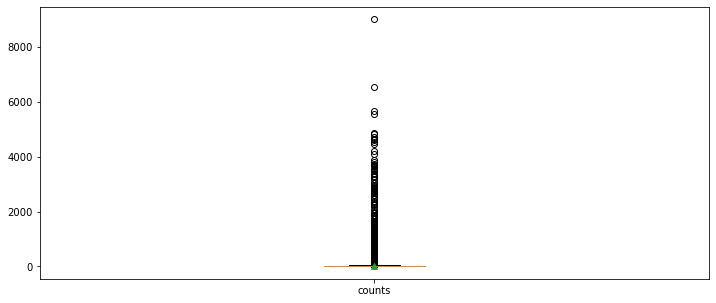

In [37]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_counts,
           labels=['counts'],
           showmeans=True)

워드 클라우드를 통해 어떤 단어가 많이 나오는지 확인 

(-0.5, 799.5, 599.5, -0.5)

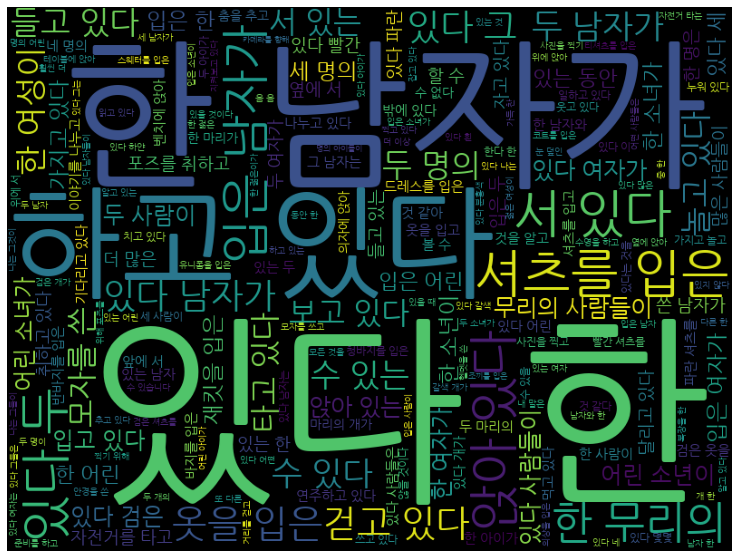

In [38]:
from wordcloud import WordCloud
font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate("".join(train_set.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

"gold_label"에 포함된 수반, 모순, 중립의 세 가지 값의 분포를 확인  
- **수반**은 전체와 가설이 참일 때
- **모순**은 전제와 가설이 거짓일 때 
- **중립**은 관계가 없는 전제와 가설

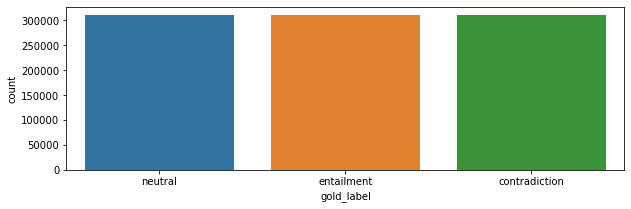

In [39]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 3)
sns.countplot(train_data['gold_label'])

30만 개 이상의 세 가지 값의 분포가 동일한 학습 데이터이다.  

### 2) KorNLI 데이터 전처리  
encode_plus에 text_pair 옵션을 지정해 형식에 맞게 기능을 추가 

In [41]:
#random seed 고정

tf.random.set_seed(1234)
np.random.seed(1234)

# BASE PARAM

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 24 * 2 # Average total * 2 (이 모델은 문장을 2개 사용하기 때문)

DATA_IN_PATH = './data_in/KOR' # 경로 설정 
DATA_OUT_PATH = "./data_out/KOR"

KorNLI 데이터셋은 학습 데이터에 SNLI와 XNLI, 검증데이터에 DEV_XNLI 데이터셋이 있으므로 학습과 검증에 필요한 학습 데이터셋 3개를 불러온다. 

In [42]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna() # dropna로 결측 데이터 제거 
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

Total # dataset: train - 942808, dev - 2490


In [43]:
# 감정 분류에서 활용했ㄷ건 버트 토크나이저에 자연어 추론 구조에 맞게 수정한 코드와 전처리 과정 적용 
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [44]:
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_snli_xnli_input_ids = np.array(input_ids, dtype=int)
train_snli_xnli_attention_masks = np.array(attention_masks, dtype=int)
train_snli_xnli_type_ids = np.array(token_type_ids, dtype=int)
train_snli_xnli_inputs = (train_snli_xnli_input_ids, train_snli_xnli_attention_masks, train_snli_xnli_type_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\user\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2173: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


- 감정 분류에서 사용한 버트 토크나이저와 문장의 토크나이저, 어텐션, 토큰 값을 출력
- 문장을 튜플 형식으로 묶는 방법은 같지만 2개의 문장을 합치는 과정을 진행
- bert_tokenizer_v2 는 2개의 문장을 활용해 학습 데이터를 만드는 과정으로 bert_tokenizer와 차이를 두어 명시
- encode_plus 기능에 text_pair를 추가하면 2개의 문장을 받아 버트의 입력에 맞게 만들어 줌 

In [46]:
input_id = train_snli_xnli_input_ids[2]
attention_mask = train_snli_xnli_attention_masks[2]
token_type_id = train_snli_xnli_type_ids[2]

print(input_id) 

[  101  9251 10622  9847 97802  8888 13890 33305  9379 25549 12310  9619
 11261  9150 12965 28188 66346   119   102  9405 61250 10892  9538 78705
 11489  9251 10622  9845 11664 11506   119   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [47]:
print(attention_mask)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [48]:
# 2개 문장에 대한 자연어 추론
print(token_type_id)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [49]:
# 토큰 인덱스를 다시 한글로 치환
print(tokenizer.decode(input_id))

[CLS] 말을 탄 사람이 고장난 비행기 위로 뛰어오른다. [SEP] 사람은 야외에서 말을 타고 있다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


- 토크나이저 작업 이후에는 라벨 데이터셋에도 간단한 전처리 작업이 필요  
- 데이터셋 라벨은 3개의 텍스트로 구성돼 있어 인테스 형태로 변환  

In [51]:
# 라벨을 Neutral, Contradiction, Entailment에서 숫자형으로 변경 
label_dict = {"entailment": 0, "contradiction":1, "neutral":2}
def convert_int(label):
    num_label = label_dict[label]
    return num_label

train_data_xnli["gold_label_int"] = train_data_xnli["gold_label"].apply(convert_int)
train_snli_xnli_labels = np.array(train_data_xnli['gold_label_int'], dtype=int)

print("# sents : {}, # labels: {}".format(len(train_snli_xnli_input_ids), len(train_snli_xnli_labels)))

# sents : 942808, # labels: 392702


# DEV SET Preprocessing

In [52]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_xnli_input_ids = np.array(input_ids, dtype=int)
dev_xnli_attention_masks = np.array(attention_masks, dtype=int)
dev_xnli_type_ids = np.array(token_type_ids, dtype=int)
dev_xnli_inputs = (dev_xnli_input_ids, dev_xnli_attention_masks, dev_xnli_type_ids)

In [53]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [54]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=3)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [55]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [56]:
#학습 진행하기
model_name = "tf2_KorNLI"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_snli_xnli_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_xnli_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

./data_out/KOR\tf2_KorNLI -- Folder create complete 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


 1523/29463 [>.............................] - ETA: 136:41:34 - loss: 0.8534 - accuracy: 0.6077

KeyboardInterrupt: 

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

학습 결과를 보면 검증 데이터의 피어슨 상관계수의 경우 두 번째 에폭에서 가장 높은 성능을 보여준다.  
데이터 수도 많지 않기 때문에 빠르게 수렴하는 모습을 확인할 수 있다. 이제 가장 높은 검증 데이터 성능을 보인 가중치를 가지고 테스트를 진행해보자. 

# KorNLI Test dataset

In [57]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
test_data_xnli = test_data_xnli.dropna()
test_data_xnli.head()

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment


In [58]:
# Test set도 똑같은 방법으로 구성한다.

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
    
test_xnli_input_ids = np.array(input_ids, dtype=int)
test_xnli_attention_masks = np.array(attention_masks, dtype=int)
test_xnli_type_ids = np.array(token_type_ids, dtype=int)
test_xnli_inputs = (test_xnli_input_ids, test_xnli_attention_masks, test_xnli_type_ids)

C:\Users\user\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2173: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [59]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_xnli_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_xnli_input_ids), len(test_data_xnli_labels)))

# sents: 5010, # labels: 5010


In [60]:
results = cls_model.evaluate(test_xnli_inputs, test_data_xnli_labels, batch_size=512)
print("test loss, test acc: ", results)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


10/10 [==============================] - 447s 45s/step - loss: 0.9033 - accuracy: 0.5802
test loss, test acc:  [0.9033348560333252, 0.5802395343780518]
